In [91]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.preprocessing import *

In [124]:
def preprocess(df):
    df['preprocess'] = df.apply(lambda row: remove_retweets(row['tweet']), axis=1)
    df['preprocess'] = df.apply(lambda row: remove_mentions(row['preprocess']), axis=1)
    #df['preprocess'] = df.apply(lambda row: remove_urls(row['preprocess']), axis=1)
    df['preprocess'] = df.apply(lambda row: remove_hashtags(row['preprocess']), axis=1)
    df['preprocess'] = df.apply(lambda row: remove_additional_space(row['preprocess']), axis=1)
    df['preprocess'] = df.apply(lambda row: replace_slash_chars_by_space(row['preprocess']), axis=1)
    df['preprocess'] = df.apply(lambda row: remove_underscore(row['preprocess']), axis=1)
    df['preprocess'] = df.apply(lambda row: remove_emojis(row['preprocess']), axis=1)
    with open('../data/english_stopwords.txt', 'r') as f:
        stopwords = f.read().split('\n')
    df['preprocess'] = df.apply(lambda row: row['preprocess'].lower(), axis=1)
    to_remove_stopwords = ["not", "no", "wouldn't", "shouldn't", "couldn't", "won't", "can't", "doesn't", "isn't", "wasn't", "don't"]
    final_stopwords = [s for s in stopwords if s not in to_remove_stopwords]
    df['preprocess'] = df.apply(lambda row: remove_stopwords(row['preprocess'], final_stopwords), axis=1)
    
    return df

In [125]:
data_path = "../data/"
database = "final_merged_dataset.csv"
df = pd.read_csv(data_path + database)
df['Unnamed: 0'] = [i for i in range(len(df))] #c'est moche mais ca marche c'est la vie 
df.columns = ['index', 'tweet', 'label']

df = preprocess(df)
print(df.tail())

       index                                              tweet  label  \
31996  31996  https://t.co/inx3HTRcfR Smell Diminishes by Da...      1   
31997  31997  COVID-19 outbreak on the Diamond Princess crui...      1   
31998  31998  Coronavirus China Italy | Coronavirus Outbreak...      1   
31999  31999  Coronavirus Daily Digest: April 13, 2020\nhttp...      1   
32000  32000  Detention centers are notorious for having poo...      1   

                                              preprocess  
31996  https://t.co/inx3htrcfr smell diminishes day 3...  
31997  covid-19 outbreak diamond princess cruise ship...  
31998  coronavirus china italy | coronavirus outbreak...  
31999  coronavirus daily digest: april 13, 2020 https...  
32000  detention centers notorious poor conditions &a...  


In [131]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = df['preprocess'] # use 'preprocess' for preprocessed tweets, 'tweet' for unpreprocessed

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(max_features = 20, analyzer = stemmed_words)

vectorizer.fit(corpus)
X = vectorizer.transform(corpus).toarray()
Y = df['label']

In [132]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
transformer.fit(X)
X = transformer.transform(X).toarray()

In [133]:
print(vectorizer.get_feature_names())

['19', 'amp', 'case', 'co', 'confirm', 'coronaviru', 'covid', 'covid19', 'death', 'health', 'http', 'new', 'not', 'peopl', 'report', 'state', 'test', 'vaccin', 'via', 'viru']


In [134]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold, cross_val_score

clf = RandomForestClassifier(n_estimators=50)

score = cross_val_score(clf, X , Y)
print('Mean : %.2f' % score.mean())
print('Std :  %.2f' % score.std())

Mean : 0.74
Std :  0.06


In [135]:
from sklearn.metrics import classification_report
folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=0) 

count = 0
for train_index, test_index in kf.split(X,Y):
    count += 1
    X_train, X_test = X[train_index, :], X[test_index, :]
    Y_train, Y_test = Y[train_index], Y[test_index]
               
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    print('Fold : ', count)
    print(classification_report(Y_pred, Y_test))

Fold :  1
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      2612
           1       0.86      0.79      0.82      3789

    accuracy                           0.80      6401
   macro avg       0.79      0.80      0.80      6401
weighted avg       0.80      0.80      0.80      6401

Fold :  2
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2662
           1       0.86      0.80      0.83      3738

    accuracy                           0.81      6400
   macro avg       0.80      0.81      0.81      6400
weighted avg       0.81      0.81      0.81      6400

Fold :  3
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      2613
           1       0.86      0.80      0.83      3787

    accuracy                           0.80      6400
   macro avg       0.80      0.81      0.80      6400
weighted avg       0.81      0.80      0.81 

Avec train_test_split classique :

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print(classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3492
           1       0.91      0.89      0.90      4509

    accuracy                           0.89      8001
   macro avg       0.88      0.89      0.89      8001
weighted avg       0.89      0.89      0.89      8001



(array([10869.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 13131.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

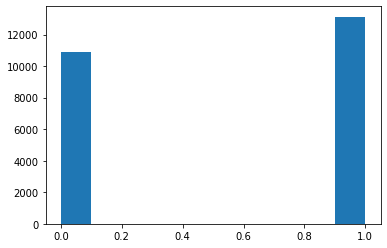

In [99]:
plt.hist(Y_train)

In [100]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, Y_pred))

[[3102  514]
 [ 390 3995]]


In [101]:
errors = pd.DataFrame({'location': [], 'text' :[], 'value': [], 'predicted': []})
for i in range(len(Y_pred)):
    if Y_test.values[i] - Y_pred[i] != 0:
        errors = errors.append({
            'location': Y_test.index[i],
            'text': df['tweet'][Y_test.index[i]],
            'preprocess': df['preprocess'][Y_test.index[i]],
            'predicted': Y_pred[i],
            'value': Y_test.values[i]
        }, ignore_index= True)
 
print(errors)

     location                                               text  value  \
0     30695.0  @ChuckCallesto Wearing a cloth face cover will...    1.0   
1      9846.0  RT @PIB_India: Over 38.5 lakh patients have so...    1.0   
2     13490.0  #coronavirus #Covid19 or #NYC NYC Millions wil...    0.0   
3     29596.0  COVID-19 Breast Cancer Patient Triage Guidelin...    1.0   
4      7401.0  People in Italy are throwing money on the road...    0.0   
..        ...                                                ...    ...   
899    1428.0  When will we get a vaccine? #COVIDー19 #coronav...    0.0   
900    3965.0  ???Covid is never going away! This is the beac...    0.0   
901    6682.0  ???How many of you are aware that the female g...    0.0   
902   14358.0  Delhi Public School Selling Face Masks For Rs....    0.0   
903    1191.0  Israeli Researchers Near Covid-19 Vaccine Deve...    0.0   

     predicted                                         preprocess  
0          0.0  wearing cloth f

In [102]:
for error in errors.head().iterrows():
    print('Sample error : \n', error[1]['text'], '\n')
    print('Preprocessed error : \n', error[1]['preprocess'], '\n')
    print('Line : ', error[1]['location'])
    print('Predicted value : ', error[1]['predicted'] , '\nReal value : ', error[1]['value'], '\n')
    print('_______________________________________________\n')

Sample error : 
 @ChuckCallesto Wearing a cloth face cover will not prevent virus particles from getting through. I think they should be optional. If you are sick stay home, unfortunately 60% or more are asymtomatic when infected with the coronavirus. 

Preprocessed error : 
 wearing cloth face cover not prevent virus particles getting through. think optional. sick stay home, unfortunately 60% asymtomatic infected coronavirus. 

Line :  30695.0
Predicted value :  0.0 
Real value :  1.0 

_______________________________________________

Sample error : 
 RT @PIB_India: Over 38.5 lakh patients have so far recovered and discharged. The rate of recovery on day to day basis is showing an increas… 

Preprocessed error : 
 38.5 lakh patients far recovered discharged. rate recovery day day basis showing increas… 

Line :  9846.0
Predicted value :  0.0 
Real value :  1.0 

_______________________________________________

Sample error : 
 #coronavirus #Covid19 or #NYC NYC Millions will be infecte

In [103]:
words_error = []
for error in errors['text']:
    error_text = re.sub(r'[^\w\s]', '', error)
    words_error += word_tokenize(error_text)

my_stopwords = set(stopwords.words('english')) 

n = 2
words_error = [word for word in words_error if not word in my_stopwords]
ngram_all=(pd.Series(nltk.ngrams(words_error, n)).value_counts())[:30]
ngram_all=pd.DataFrame(ngram_all)
print(ngram_all)

                          0
(tested, positive)       12
(COVID19, vaccine)       10
(social, media)          10
(coronavirus, COVID19)   10
(clinical, trials)        9
(President, Trump)        9
(coronavirus, hoax)       8
(COVID19, cases)          8
(confirmed, case)         8
(United, States)          8
(new, infections)         7
(coronavirus, vaccine)    7
(COVID, 19)               7
(coronavirus, cases)      6
(World, Health)           6
(The, CDC)                6
(every, country)          6
(stay, home)              6
(novel, coronavirus)      6
(immune, system)          6
(positive, COVID19)       6
(The, Coronavirus)        6
(via, YouTube)            6
(COVID, Tracer)           6
(Vitamin, D)              6
(NZ, COVID)               6
(coronavirus, pandemic)   6
(posters, created)        5
(like, flu)               5
(seasonal, flu)           5
